# Human Activity Recognition

The videos are present in a directory called `'Data'`. I have used the `load_files()` function available in scikit-learn to get the absolute paths of these videos and their respective class labels. These paths will be later used to read the videos in the required format.

For detailed information on `load_files()`, read the documantation [here](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_files.html)

The whole data in randomly split into training and test data, with **test data being 1/5 of the total data**.
Also, approximately **33% of the training data will be used as the _validation set_**.

**Total Videos : 598**

**Training Videos : 360  ~ 60% of total videos**

**Validation Videos :118 ~ 19.7% of  total videos**

**Testing Videos : 120  ~ 20% of total videos**

In [1]:
#Library Importing

# Imports
import os
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

# Imports
import numpy as np
import matplotlib.pyplot as plt
from utils import Videos
%matplotlib inline


# Imports
import numpy as np
from keras.utils import to_categorical
from utils import Videos

# Imports
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, BatchNormalization
from keras.layers.core import Dense, Dropout

# Imports
from keras.callbacks import ModelCheckpoint

# Imports
import numpy as np
from keras.utils import to_categorical
from utils import Videos

Using TensorFlow backend.


In [2]:
# Loading the data
raw_data = load_files(os.getcwd() + r'/Data', shuffle=False)
files = raw_data['filenames']
targets = raw_data['target']

# Randomly dividing the whole data into training (80%) and testing (20%) data 
train_files, test_files, train_targets, test_targets = train_test_split(files, targets, test_size=1/5, random_state=191)

# Taking ~24% of the training data for validation
valid_files = train_files[360:600]
valid_targets = train_targets[360:600]

# Remaining data will be used for training the model
train_files = train_files[0:360]
train_targets = train_targets[0:360]

# Generic details about the data
print('Total number of videos:', len(files))
print('\nNumber of videos in training data:', train_files.shape[0])
print('Number of videos in validation data:', valid_files.shape[0])
print('Number of videos in test data:', test_files.shape[0])

Total number of videos: 598

Number of videos in training data: 360
Number of videos in validation data: 118
Number of videos in test data: 120


### Description of the class labels

In [3]:
print('The categorical labels are converted into integers.\nFollowing is the mapping - \n')
for label in zip(range(6), raw_data['target_names']):
    print(label)

The categorical labels are converted into integers.
Following is the mapping - 

(0, 'boxing')
(1, 'handclapping')
(2, 'handwaving')
(3, 'jogging')
(4, 'running')
(5, 'walking')


### Each video file is associated with its class label

In [4]:
# Displaying the first 5 videos (paths) in the training data along with their labels
# (path of video, class label)
for pair in zip(train_files[:5], train_targets[:5]):
    print(pair)

('/tf/Human-Activity-Recognition-master/Data/jogging/person01_jogging_d3_uncomp.avi', 3)
('/tf/Human-Activity-Recognition-master/Data/jogging/person07_jogging_d4_uncomp.avi', 3)
('/tf/Human-Activity-Recognition-master/Data/boxing/person05_boxing_d2_uncomp.avi', 0)
('/tf/Human-Activity-Recognition-master/Data/walking/person08_walking_d4_uncomp.avi', 5)
('/tf/Human-Activity-Recognition-master/Data/handwaving/person02_handwaving_d2_uncomp.avi', 2)


## Exploring the video dataset

There is a helper class called `Videos` in `utils.py` for reading the videos into *numpy ndarrays*.

The class provides some additional functionalities like:

- Setting the target size for each frame of a video
- Conversion each frame to gray scale
- Various options to extract a subset of frames from each video
- Normalizing the pixel values of each video

We will use this to load out training, validation and test data.

### Let's load a sample of the training data *as it is*.

  0%|          | 0/1 [00:00<?, ?it/s]

['/tf/Human-Activity-Recognition-master/Data/jogging/person01_jogging_d3_uncomp.avi']


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Shape of the sample data: (1, 405, 128, 128, 3)


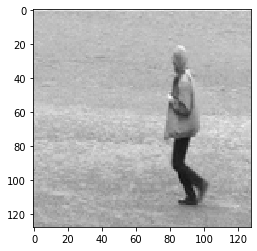

In [5]:
# The path of a sample video in the training data
sample_files = train_files[:1]
print(sample_files)

# An object of the class 'Videos'
reader = Videos(target_size=(128,128), to_gray=False)

# Loading the sample videos, in their original format
sample = reader.read_videos(sample_files)
print('\nShape of the sample data:', sample.shape)

# Displaying a frame from the sample video
plt.imshow(sample[0][15])

The shape of the tensor obtained is **(1, 405, 128, 128, 3)**.

This indicates that:

- There is **1 video**.
- The video has **405 frames**.
- The dimension of **each frame is 128x128 pixels**.
- There are **3 channels** for each frame - Red(R), Green(G) and Blue(B)

---

## Pre-processing the Data

### Conversion of frames to gray scale
In order to simplify the computations and complexity of our models, the *frames could be converted to gray scale*. Also, since we intend the model to learn the movement patterns of the human subjects, the *color aspect of the video would not matter*.

### Frame Extraction
The dataset contains **video of varying length**. This means that the number of frames in each video is not the same. *In order to stack the videos in a tensor, each video should have the same number of frames*. Therefore, we would have to select the same number of frames from each video.

Now, when it comes to frame selection, there can be several techniques.

Suppose we want 'N' frames (N/25 seconds) for each video. *These frames should be contiguous* (i.e., the frames should not be selected randomly) so that our model can detect the patterns successfully. 

We can follow one of the 3 obvious strategies:
1. Extract the **first N frames** from each video
2. Extract the **last N frames** from each video
3. Extract **N frames from the middle**.  
    Let's say that the video has 'M' frames in total. If we select N frames, there are (M - N) frames left.
    In order to do frame selection from the middle of the video, we would *remove the first (M - N)/2 frames* and the *last (M - N)/2 frames*.
    
### Dimensions of each frame in a video
We might have a situation where the *spatial dimensions (width and height) of the frames could be different in different videos*. In such a case, our model would fail to function properly. Therefore, we would require *each frame in every video to have the same spatial dimension*.

Fortunately, in our dataset, every video has the spatial dimension of 120x160 pixels. But,we will resize each video to have a spatial dimension of 128x128 pixels

### Pixel Normalization
Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network.

The pixel value ranges from 0 to 255. So, we will bring it in the range [0, 1].

** The helper function `read_videos()` that we used before provides the functionality to do all of these _customizations_.**

### One-hot Encoding
**Categorical labels** should be encoded using this technique called *One-hot Encoding*.

Example-

*Before One-hot encoding*

| Class Label | Mapped Integer |
| :---------: | :------------: |
| Boxing | 0 |
| Handclapping | 1 |
| Handwaving | 2 |
| Jogging | 3 |
| Running | 4 |
| Walking | 5 |

*After One-hot encoding*

| Class Label | 0 | 1 | 2 | 3 | 4 | 5 |
| :---------: | - | - | - | - | - | - |
| Boxing | 1 | 0 | 0 | 0 | 0 | 0 |
| Handclapping | 0 | 1 | 0 | 0 | 0 | 0 |
| Handwaving | 0 | 0 | 1 | 0 | 0 | 0 |
| Jogging | 0 | 0 | 0 | 1 | 0 | 0 |
| Running | 0 | 0 | 0 | 0 | 1 | 0 |
| Walking | 0 | 0 | 0 | 0 | 0 | 1 |

We will use the `to_categorical()` functions provided by the `keras.utils` module for one-hot encoding the labels.  
For further details, read the documentation [here](https://keras.io/utils/#to_categorical)

---

We will now load the data where:

- Each video will have a spatial dimension of 128x128 pixels
- Each video will have a maximum of 40 frames (extracted from the first)
- The pixels will be normalized to the range [0, 1]
- The class labels are One-hot Encoded

## Processing of the data
We know that the human body performs these activities (running, boxing etc.) with a certain speed. Within one second, the human body does not make much of a movement. Therefore, we do not need to collect each and every frame for each second of video that we are capturing. A different approach could be used, where only a certain number of frames are extraced for each second. 

So, suppose we have a video with a time duration of 10 seconds.We have extracted 10x25 = 250 frames. Then, we would have selected 200 frames from the middle (leaving out 25 frames from front and back).  
But, with our method, we would be extracting only a few frames per second (say 5). We would then have a total of 10x5 = 50 frames extracted. Also, we can still put a limit on the maximum number of frames that we want (say 40), then out of these 50 frames, 40 would be selected (from front, last or middle).

We can therefore see that the **size of the data got reduced by a large factor** (in this example, by 5 times). This could be a great advantage for our model training as our model would now take less time to train. Also, since we have saved some time here, we can improve the model by making it deeper (adding more layers). The model can still learn patterns from the training data accurately because **the data that we removed was just redundant**.

The helper function `read_videos()` has the functionality to do this via a parameter called `required_fps`.

- For our model, we would set the value of `required_fps` to **5**.
- The range of normalized pixels has also been changed from [0, 1] to [-1, 1]. This is because the mean of the pixels would then be 0, which would *help the model converge faster*.

In [6]:
# An object of the class `Videos` to load the data in the required format
reader = Videos(target_size=(128, 128), 
                to_gray=True, 
                max_frames=40, 
                extract_frames='first', 
                required_fps=5, 
                normalize_pixels=(-1, 1))

In [7]:
# Reading training videos and one-hot encoding the training labels
X_train = reader.read_videos(train_files)
y_train = to_categorical(train_targets, num_classes=6)
print('Shape of training data:', X_train.shape)
print('Shape of training labels:', y_train.shape)

100%|██████████| 360/360 [02:42<00:00,  2.22it/s]


Shape of training data: (360, 40, 128, 128, 1)
Shape of training labels: (360, 6)


In [8]:
# Reading validation videos and one-hot encoding the validation labels
X_valid = reader.read_videos(valid_files)
y_valid = to_categorical(valid_targets, num_classes=6)
print('Shape of validation data:', X_valid.shape)
print('Shape of validation labels:', y_valid.shape)

100%|██████████| 118/118 [00:52<00:00,  2.25it/s]


Shape of validation data: (118, 40, 128, 128, 1)
Shape of validation labels: (118, 6)


In [9]:
# Reading testing videos and one-hot encoding the testing labels
X_test = reader.read_videos(test_files)
y_test = to_categorical(test_targets, num_classes=6)
print('Shape of testing data:', X_test.shape)
print('Shape of testing labels:', y_test.shape)

100%|██████████| 120/120 [00:51<00:00,  2.34it/s]


Shape of testing data: (120, 40, 128, 128, 1)
Shape of testing labels: (120, 6)


### Our Model

In [10]:
# Using the Sequential Model
model = Sequential()

# Adding Alternate convolutional and pooling layers
model.add(Conv3D(filters=16, kernel_size=(5, 3, 3), strides=(1, 1, 1), padding='same', activation='relu', 
                 input_shape=(40, 128, 128, 1)))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

model.add(Conv3D(filters=64, kernel_size=(2, 3, 3), strides=(1, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

model.add(Conv3D(filters=1024, kernel_size=(2, 3, 3), strides=(1, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

# A global average pooling layer to get a 1-d vector
# The vector will have a depth (same as number of elements in the vector) of 1024
model.add(GlobalAveragePooling3D())

# Hidden layer
model.add(Dense(32, activation='relu'))

# Hidden layer
model.add(Dense(512, activation='relu'))

#Dropout layer
model.add(Dropout(0.25))

# Output layer
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 40, 128, 128, 16)  736       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 20, 64, 64, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 19, 62, 62, 64)    18496     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 10, 31, 31, 64)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 9, 29, 29, 1024)   1180672   
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 5, 15, 15, 1024)   0         
_________________________________________________________________
global_average_pooling3d_1 ( (None, 1024)             

### Our Model 

We are train our model for 50 epochs on the training data and saving the weights of the model that performed the best on the validation data. And we are also setting the checkpoints . If our condition satisfy , we will stop the model for further training.

Also, the optimizer used is `NADAM` instead of `ADAM`.

##### Checkpoints
After doing lot of tuning we choosed validation loss as our check point.

In [11]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.48):
          print("\nReached less than 48% validation loss!")
          self.model.stop_training = True
            
#callback=myCallback()

In [12]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [14]:
# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model.weights.best.hdf5', save_best_only=True, verbose=1)

# Training the model for 15 epochs
history = model.fit(X_train, y_train, batch_size=13, epochs=50, 
                    validation_data=(X_valid, y_valid), verbose=2, callbacks=[checkpoint,myCallback()])

Train on 360 samples, validate on 118 samples
Epoch 1/50
 - 47s - loss: 1.8131 - accuracy: 0.1139 - val_loss: 1.7851 - val_accuracy: 0.2203

Epoch 00001: val_loss improved from inf to 1.78510, saving model to Model.weights.best.hdf5
Epoch 2/50
 - 40s - loss: 1.7376 - accuracy: 0.2611 - val_loss: 1.6356 - val_accuracy: 0.2288

Epoch 00002: val_loss improved from 1.78510 to 1.63555, saving model to Model.weights.best.hdf5
Epoch 3/50
 - 40s - loss: 1.5755 - accuracy: 0.2944 - val_loss: 1.3430 - val_accuracy: 0.4237

Epoch 00003: val_loss improved from 1.63555 to 1.34305, saving model to Model.weights.best.hdf5
Epoch 4/50
 - 40s - loss: 1.2483 - accuracy: 0.3361 - val_loss: 1.1102 - val_accuracy: 0.4153

Epoch 00004: val_loss improved from 1.34305 to 1.11023, saving model to Model.weights.best.hdf5
Epoch 5/50
 - 40s - loss: 1.1708 - accuracy: 0.3806 - val_loss: 1.0131 - val_accuracy: 0.5169

Epoch 00005: val_loss improved from 1.11023 to 1.01313, saving model to Model.weights.best.hdf5
Epo

### Evaluating Model

Evaluating model on the test data.

In [13]:
# Loading the model that performed the best on the validation set
model.load_weights('Model.weights.best.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=14, verbose=2)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

Accuracy on test data: 85.83%


## Our Model Performance

The model gave an **Accuracy of 85.83% on the test data**.


### Learning Curve

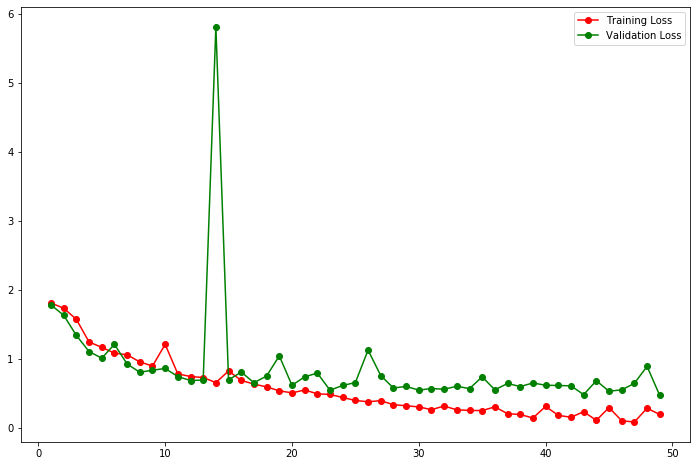

In [16]:
# Making the plot larger
plt.figure(figsize=(12, 8))

loss = history.history['loss']                          # Loss on the training data
val_loss = history.history['val_loss']                  # Loss on the validation data
epochs = range(1,50)

plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')
plt.legend()

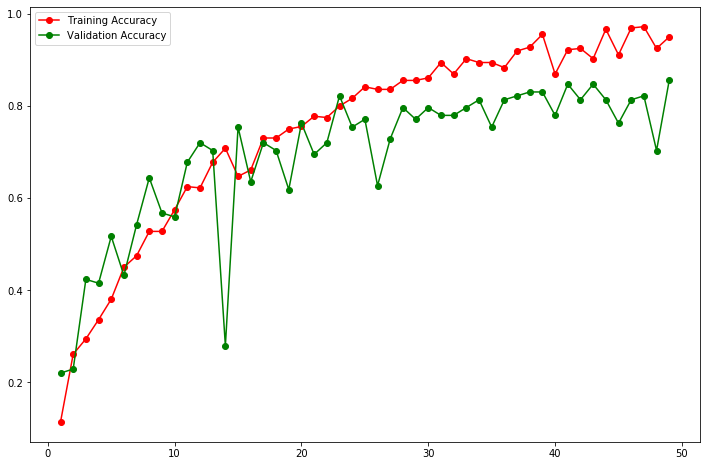

In [18]:
# Making the plot larger
plt.figure(figsize=(12, 8))

accuracy = history.history['accuracy']                          # Loss on the training data
val_accuracy = history.history['val_accuracy']                  # Loss on the validation data
epochs = range(1,50)

plt.plot(epochs, accuracy, 'ro-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'go-', label = 'Validation Accuracy')
plt.legend()

From the learning curve, it is evident that the model overfitting is going down as epochs increasing  and if it would have been trained more, the model could have performed better. The model gave an accuracy of 85.83% on the test data, which is the very good.

## Comparision with the Benchmark Model

Finally, we will compare our model with the benchmark model that we selected. **The benchmark model used a test data of 9 persons**. So, *we will select the videos of 9 persons (randomly) performing each of these actions*. We will then predict the outcomes of these videos using our model. In order to compare our model with the benchmark model, we would use the confusion matrix of these models.

    Note: 
    The instructions on the selection of these 9 persons was not available, therefore they have been selected randomly.

In [16]:
# Imports
import numpy as np
np.random.seed(141)

# Choosing 9 random persons (unique)
people = np.arange(1, 26)
chosen = np.random.choice(people, 9, replace=False)

print('The following people are chosen:', chosen)

# Selecting the paths of all the videos of these persons from our entire dataset
bench_files = []
indexes = []
for index in chosen:
    for i, path in enumerate(raw_data['filenames']):
        if (('person' + str(index)) in path) or (('person0' + str(index)) in path):
            bench_files.append(path)
            indexes.append(i)
            
bench_files = np.array(bench_files)
bench_targets = raw_data['target'][indexes]

The following people are chosen: [11 21 19 14 25 10 15  6  5]


### Reading in the data in the same format that was used before

In [17]:
# An object of the class `Videos` to load the data in the required format
reader = Videos(target_size=(128, 128), 
                to_gray=True, 
                max_frames=40, 
                extract_frames='first', 
                required_fps=5, 
                normalize_pixels=(-1, 1))

In [18]:
bench_video = reader.read_videos(bench_files)
bench_target = to_categorical(bench_targets, num_classes=6)
print('Shape of training data:', bench_video.shape)
print('Shape of training labels:', bench_target.shape)

100%|██████████| 216/216 [01:47<00:00,  2.01it/s]


Shape of training data: (216, 40, 128, 128, 1)
Shape of training labels: (216, 6)


So, now we have 216 videos (24 videos for each of the 9 person). We will load our model and evaluate the performance of the model on this data.

In [19]:
# Loading the model that performed the best on the validation set
model.load_weights('Model.weights.best.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model.evaluate(bench_video, bench_target, batch_size=14, verbose=2)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

Accuracy on test data: 92.13%


The model gave an **accuracy of ~92.13%** on the data of 9 persons.

## The Benchmark Model

The following model is used as a benchmark - [Recognizing Human Actions: A Local SVM Approach](http://ftp.nada.kth.se/CVAP/users/laptev/icpr04actions.pdf)

Below is the confusion matrix obtained from this model:
![Benchmark Confusion Matrix](images/benchmark_result.PNG)

The confusion matrix has been normalized (the sum of each row is equal to 100).

- We would have modify the order of classes of the confusion matrix. 
- Also, we will get the values in range [0, 1] (by dividing by 100).  
This is done so as to *simplify the comparision of the confusion matrix with that of our model*.

In [20]:
# Changed the sequence of the classes
benchmark_cnf_matrix = [
    [0.979, 0.07, 0.07, 0.0, 0.0, 0.07], 
    [0.354, 0.597, 0.035, 0.0, 0.0, 0.014], 
    [0.208, 0.049, 0.736, 0.0, 0.0, 0.07], 
    [0.0, 0.0, 0.0, 0.604, 0.167, 0.229], 
    [0.0, 0.0, 0.0, 0.389, 0.549, 0.063], 
    [0.0, 0.0, 0.0, 0.162, 0.0, 0.838]
]

benchmark_cnf_matrix = np.array(benchmark_cnf_matrix)

#### Below is a function for plotting the confusion matrix of the Benchmark model.
The code is taken from [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

In [21]:
import itertools
def confusion_matrix_plot(cm, classes, 
                          title='Normalized Confusion Matrix', 
                          normalize=False, 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Confusion Matrix of the Benchmark Model

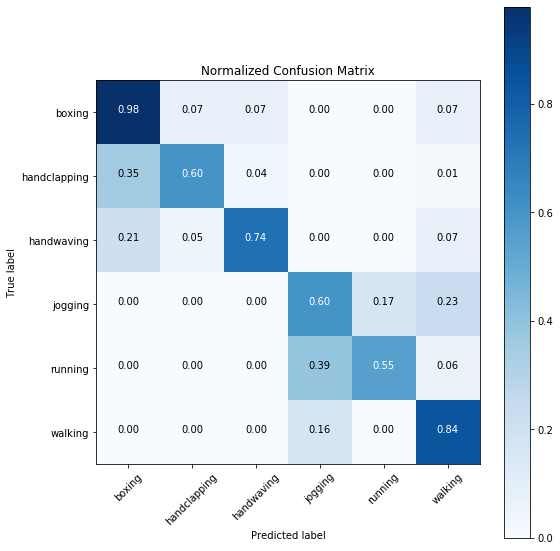

In [22]:
# Plotting the Confusion matrix of the Benchmark Model
confusion_matrix_plot(benchmark_cnf_matrix, 
                      classes=['boxing', 'handclapping', 'handwaving', 'jogging', 'running', 'walking'])

### Confusion matrix of our Model 

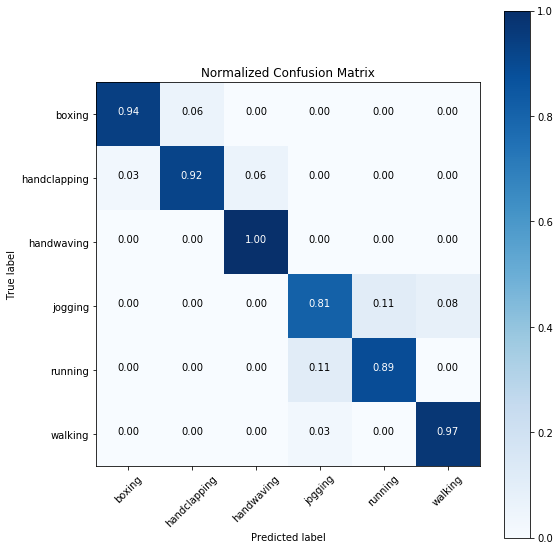

In [23]:
# Imports
from sklearn.metrics import confusion_matrix

# Getting the predictions of our Model
predictions = model.predict_classes(bench_video)

# Constructing the Confusion Matrix
model_cnf_matrix = confusion_matrix(bench_targets, predictions)

# PLotting the confusion matrix of our model
confusion_matrix_plot = confusion_matrix_plot(model_cnf_matrix, 
                                              classes=['boxing', 'handclapping', 'handwaving', 'jogging', 'running', 'walking'], 
                                              normalize=True)

---
## Problem with the Data

### The sequence of frames of a sample video of *Running*

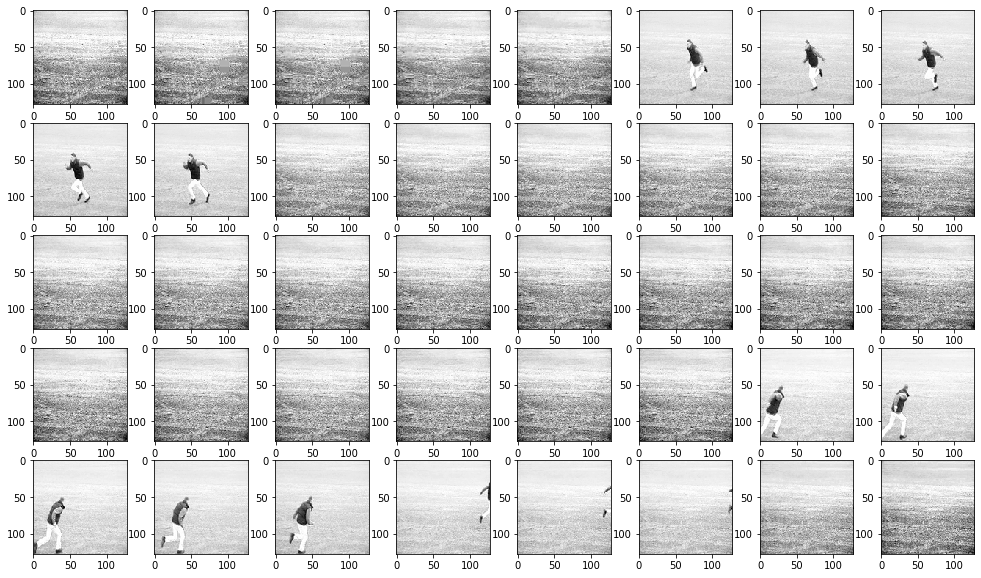

In [24]:
# Plotting the selected frames of a sample video (action being performed is running)

f, axarr = plt.subplots(5, 8, figsize=(17, 10))
row = 0
col = 0
for index, frame in enumerate(bench_video[17]):
    if index in [8, 16, 24, 32, 40]:
        row += 1
        col = 0
    axarr[row, col].imshow(np.squeeze(frame, axis=2), cmap='gray')
    col += 1

### The sequence of frames of a sample video of *Jogging*

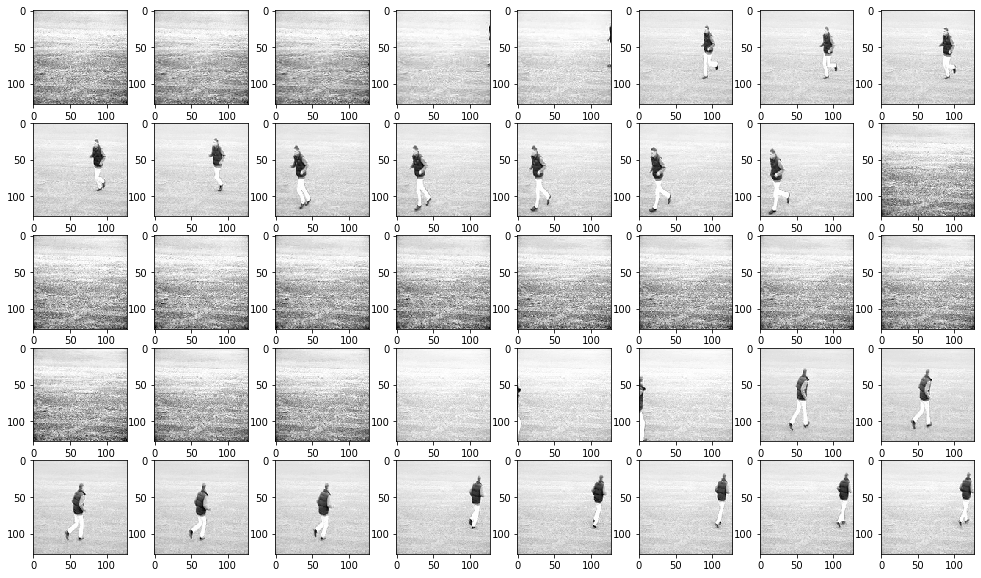

In [25]:
# Plotting the selected frames of a sample video (action being performed is jogging)

f, axarr = plt.subplots(5, 8, figsize=(17, 10))
row = 0
col = 0
for index, frame in enumerate(bench_video[13]):
    if index in [8, 16, 24, 32, 40]:
        row += 1
        col = 0
    axarr[row, col].imshow(np.squeeze(frame, axis=2), cmap='gray')
    col += 1

### The sequence of frames of a sample video of *Walking*

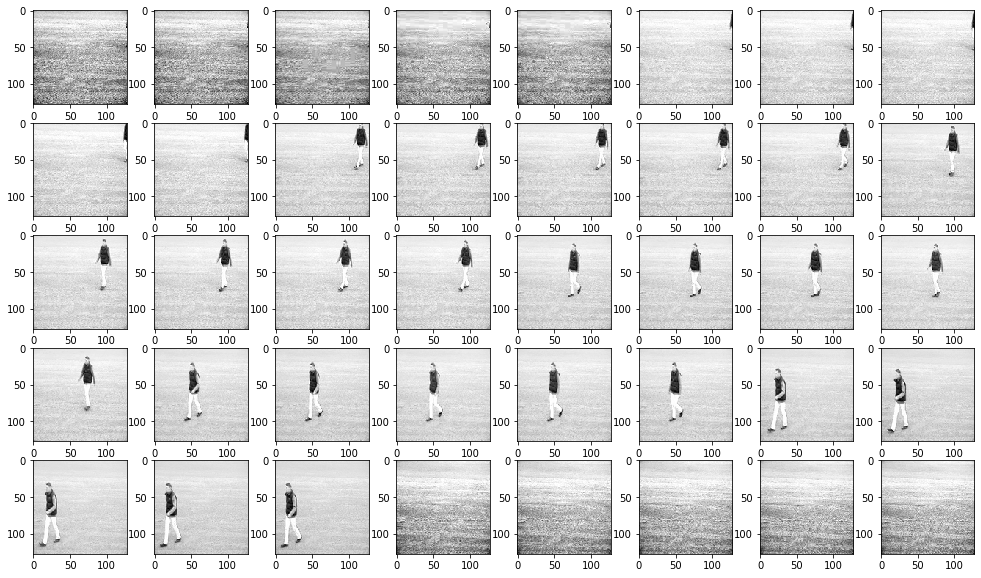

In [26]:
# Plotting the selected frames of a sample video (action being performed is walking)

f, axarr = plt.subplots(5, 8, figsize=(17, 10))
row = 0
col = 0
for index, frame in enumerate(bench_video[21]):
    if index in [8, 16, 24, 32, 40]:
        row += 1
        col = 0
    axarr[row, col].imshow(np.squeeze(frame, axis=2), cmap='gray')
    col += 1